In [18]:
# Import some libraries
import os
import numpy as np
import mne
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib qt 

# define dir
data_directory = 'C:/Users/mvmigem/Documents/data/project_1/preprocessed/localiser/'
dir_list = glob.glob(data_directory+'*')

In [13]:
# Load epochs
epochs = []
subjects = []
for i, path in enumerate(dir_list):
    sub = int(dir_list[i].split('sub')[1].split('_localiser-epo.fif')[0])
    subjects.append(sub)
    epoch = mne.read_epochs(path)
    epochs.append(epoch)

Reading C:\Users\mvmigem\Documents\data\project_1\preprocessed\localiser\sub01_localiser-epo.fif ...
    Found the data of interest:
        t =     -97.66 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
210 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\mvmigem\Documents\data\project_1\preprocessed\localiser\sub02_localiser-epo.fif ...
    Found the data of interest:
        t =     -97.66 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
184 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\mvmigem\Documents\data\project_1\preprocessed\localiser\sub03_localiser-epo.fif ...
    Found the data of interest:
        t =     -97.66 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
159 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\mv

In [ ]:
# Agragate over over all trials directly
ep_pos1 = []
ep_pos2 = []
ep_pos3 = []
ep_pos4 = []

for i, epoch in enumerate(epochs):
    ep_pos1.append(epoch['position1'])
    ep_pos2.append(epoch['position2'])
    ep_pos3.append(epoch['position3'])
    ep_pos4.append(epoch['position4'])

eps_pos1 = mne.concatenate_epochs(ep_pos1)
eps_pos2 = mne.concatenate_epochs(ep_pos2)
eps_pos3 = mne.concatenate_epochs(ep_pos3)
eps_pos4 = mne.concatenate_epochs(ep_pos4)

av_ep_pos1 = eps_pos1.average()
av_ep_pos2 = eps_pos2.average()
av_ep_pos3 = eps_pos3.average()
av_ep_pos4 = eps_pos4.average()

In [14]:
# Agragate over subs first
evokeds = []

for i, ep in enumerate(epochs):
    
    evoked_pos1 = ep['position1'].average()
    evoked_pos2 = ep['position2'].average()
    evoked_pos3 = ep['position3'].average()
    evoked_pos4 = ep['position4'].average()
    
    evoked = [evoked_pos1, evoked_pos2, evoked_pos3, evoked_pos4]
    evokeds.append(evoked)
evokeds = np.array(evokeds)
grand_av_pos1 = mne.grand_average(list(evokeds[:,0]))
grand_av_pos2 = mne.grand_average(list(evokeds[:,1]))
grand_av_pos3 = mne.grand_average(list(evokeds[:,2]))
grand_av_pos4 = mne.grand_average(list(evokeds[:,3]))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

In [ ]:
# Find peak properties to find individual tailored c1 window 
merged_ev_for_peak =[]

all_pos = []
peak_properties = ['peak_channel','peak_latency','peak_amplitude']

roi_channels = ['Oz',
                'PO3','POz','PO4',
                'P1','Pz','P2',
                'CP1','CPz','CP2',
                ]

# get peak properties of agragated erps
for i in range(20):
    av_list = list(evokeds[i,:])

    # rsq_ev_list = av_list.copy()
    for i,evoked in enumerate(av_list):
        # transform data to root squared
        ev_data = evoked.data
        rootsqr_data = np.sqrt((ev_data**2))
        rsq_ev = mne.EvokedArray(rootsqr_data,evoked.info,tmin=evoked.times[0])
        av_list[i] = rsq_ev

    merged_ev = mne.grand_average(av_list).pick(roi_channels)
    ch,lat,amp = merged_ev.get_peak(ch_type='eeg',   
                                tmin=0.05,tmax=0.09,
                                return_amplitude=True)
    all_pos.append(dict(zip(peak_properties,(ch,lat,amp))))

    merged_ev_for_peak.append(merged_ev)

    conds = ('merged')
    evoked_pos = {conds:merged_ev}
    epoch_set1 = evoked_pos
    scale = [-10, 10]
    # mne.viz.plot_compare_evokeds(epoch_set1, picks= 'Pz', vlines=[0.05,0.1],ylim=dict(eeg=scale))
    # mne.viz.plot_compare_evokeds(epoch_set1,picks='POz',vlines=[0.05,0.1],ylim=dict(eeg=scale))
grand_av_merged = mne.grand_average(merged_ev_for_peak)


In [ ]:
grand_peak_ch_name, grand_peak_latency, grand_peak_amplitude = grand_av_merged.get_peak(ch_type='eeg',tmin=0.05,tmax=0.09,return_amplitude=True)

In [ ]:
# get peak properties for every subject per position
pos1 = []
pos2 = []
pos3 = []
pos4 = []

positions = [pos1,pos2,pos3,pos4]
peak_properties = ['peak_channel','peak_latency','peak_amplitude']

for i in range(20):
    av_list = list(evokeds[i,:])
    for ind,evoked in enumerate(av_list):
        roi_ev = evoked.pick(roi_channels)
        ch,lat,amp = roi_ev.get_peak(ch_type='eeg',
                                    tmin=0.05,tmax=0.09,
                                    return_amplitude=True)
        positions[ind].append(dict(zip(peak_properties,(ch,lat,amp))))


In [ ]:
# Create dataframe to export to next script

# Add prefix
def add_prefix(lst, prefix):
    return [{f"{prefix}_{k}": v for k, v in d.items()} for d in lst]

# Add prefixes
all_pos_prefixed = add_prefix(all_pos, "all_pos")
pos1_prefixed = add_prefix(pos1, "pos1")
pos2_prefixed = add_prefix(pos2, "pos2")
pos3_prefixed = add_prefix(pos3, "pos3")
pos4_prefixed = add_prefix(pos4, "pos4")

# Convert to DataFrames

df_all = pd.DataFrame(all_pos_prefixed)
df1 = pd.DataFrame(pos1_prefixed)
df2 = pd.DataFrame(pos2_prefixed)
df3 = pd.DataFrame(pos3_prefixed)
df4 = pd.DataFrame(pos4_prefixed)

# Concatenate DataFrames side by side (axis=1)
peak_properties_dataframe = pd.concat([df_all,df1,df2,df3,df4], axis=1)
peak_properties_dataframe['grand_average_peak_channel'] = grand_peak_ch_name
peak_properties_dataframe['grand_average_peak_latency'] = grand_peak_latency
peak_properties_dataframe['grand_average_peak_amplitude'] = grand_peak_amplitude
peak_properties_dataframe['subject'] = subjects


In [ ]:
peak_properties_dataframe.to_csv(r'C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes\c1_peak_properties.csv',index= False)

In [ ]:
# Plotting
grand_av_list = [grand_av_pos1,grand_av_pos2,grand_av_pos3,grand_av_pos4]
# grand_av_list = [av_ep_pos1, av_ep_pos2, av_ep_pos3, av_ep_pos4]
conds = ('position1','position2','position3','position4')

evoked_pos = dict(zip(conds, grand_av_list))

# Plot it all
epoch_set1 = evoked_pos
scale = [-6, 6]
# mne.viz.plot_compare_evokeds(epoch_set1, picks= 'Pz', vlines=[0.05,0.1],ylim=dict(eeg=scale))
mne.viz.plot_compare_evokeds(epoch_set1,picks=['POz'],vlines=[0.05,0.1],ylim=dict(eeg=scale))
# mne.viz.plot_compare_evokeds(epoch_set1, picks= 'Oz', vlines=[0.05,0.1],ylim=dict(eeg=scale))

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

colors = ['green', 'purple', 'orange']
# Plot each evoked response in its respective subplot
grand_av_pos1.plot(picks=['PO3','POz','PO4'],axes=axes[0, 0], show=False, time_unit='s')
grand_av_pos2.plot(picks=['PO3','POz','PO4'],axes=axes[0, 1], show=False, time_unit='s')
grand_av_pos3.plot(picks=['PO3','POz','PO4'],axes=axes[1, 0], show=False, time_unit='s')
grand_av_pos4.plot(picks=['PO3','POz','PO4'],axes=axes[1, 1], show=False, time_unit='s')

# Set the line width for each subplot
line_width = 2.0  # Adjust the line width as needed

for ax in axes.flatten():  # Flatten to iterate over all subplots
    ax.axvline(x=0.05, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=0.1, color='black', linestyle='--', linewidth=1)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.1)
    for line in ax.get_lines():
        line.set_linewidth(line_width)
axes[0, 0].set_title('Top Left VF')
axes[0, 1].set_title('Top Right VF')
axes[1, 0].set_title('Bottom Left VF')
axes[1, 1].set_title('Bottom Right VF')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

C:\Users\mvmigem\AppData\Local\Temp\ipykernel_13184\1389585595.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


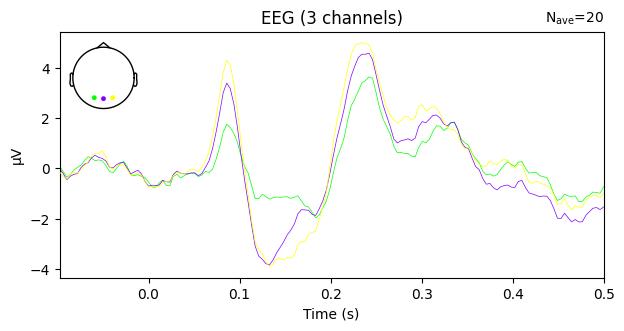

In [17]:
grand_av_pos4.plot(picks=['PO3','POz','PO4'],)

In [ ]:
times = np.linspace(0.05, 0.15, 5)
grand_av_pos1.plot_joint(times=times)

In [ ]:
times = np.linspace(0.05, 0.11, 5)
# grand_av_pos1.plot_topomap(ch_type="eeg", times=times, colorbar=True)
# grand_av_pos2.plot_topomap(ch_type="eeg", times=times, colorbar=True)
# grand_av_pos3.plot_topomap(ch_type="eeg", times=times, colorbar=True)
grand_av_pos4.plot_topomap(ch_type="eeg", times=times, colorbar=True)